In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import yaml
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
import time

In [7]:
# Check if CUDA is available
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print("Number of available GPUs:", device_count)
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")


CUDA is not available. Using CPU.


In [6]:
# For AlexNet

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels_dir = os.path.join(root_dir, 'labels')
        self.images_dir = os.path.join(root_dir, 'images')
        self.image_files = os.listdir(self.images_dir)
        self.label_files = os.listdir(self.labels_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        label_name = os.path.join(self.labels_dir, self.label_files[idx])

        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        with open(label_name, 'r') as file:
            line = file.readline().strip()
            label = int(line.split()[0])

        return image, label

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = models.alexnet(weights='DEFAULT').features
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Step 3: Define loss function and optimizer.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlexNet(num_classes=13).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Step 4: Train the model.

def train(model, train_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    
    return train_losses, train_accuracies

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load data
data_root = 'archive/train'
train_dataset = CustomDataset(data_root, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

data_root = 'archive/test'
test_dataset = CustomDataset(data_root, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

data_root = 'archive/valid'
valid_dataset = CustomDataset(data_root, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Train the model
train_losses, train_accuracies = train(model, train_loader, criterion, optimizer, num_epochs=10)

# Plotting the accuracy over epochs
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# Function to evaluate the model on a dataset and measure inference time
def evaluate_model_with_time(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    inference_time = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            start_time = time.time()  # Start measuring inference time
            outputs = model(images)
            end_time = time.time()  # End measuring inference time
            inference_time += end_time - start_time
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy, inference_time

# Evaluate the model on the test dataset and measure inference time
test_accuracy, inference_time = evaluate_model_with_time(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Inference Time: {inference_time:.4f} seconds')

KeyboardInterrupt: 

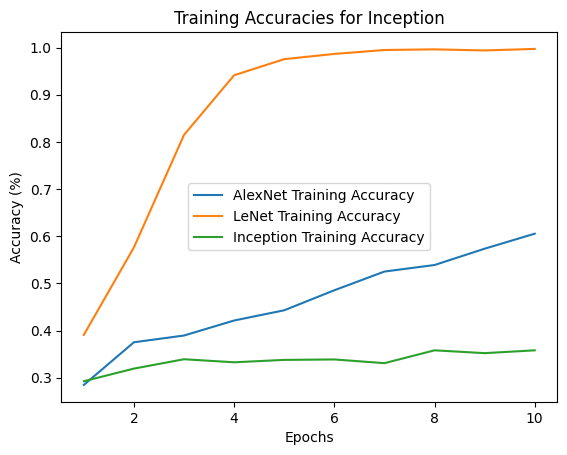

In [15]:
plt.plot(epochs, alexnet_train_accuracies, label='AlexNet Training Accuracy')
plt.plot(epochs, lenet_train_accuracies, label='LeNet Training Accuracy')
plt.plot(epochs, inception_train_accuracies, label='Inception Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracies for Inception')
plt.legend()
plt.show()